In [23]:
import textwrap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

file_path = 'IEA Dataset.xlsx'
xls = pd.ExcelFile(file_path)
df = pd.read_excel(xls, sheet_name='Sheet1')

CCUS Projects Growth and Capacity in North America

In [24]:
# Filter the dataset to include only projects located in North America (United States, Canada, Mexico)
north_america_countries = ['United States', 'Canada', 'Mexico']
df_north_america = df[df['Country'].isin(north_america_countries)]

# Grouping the data by Announcement year and counting the number of projects
projects_per_year = df_north_america.groupby('Announcement').size()

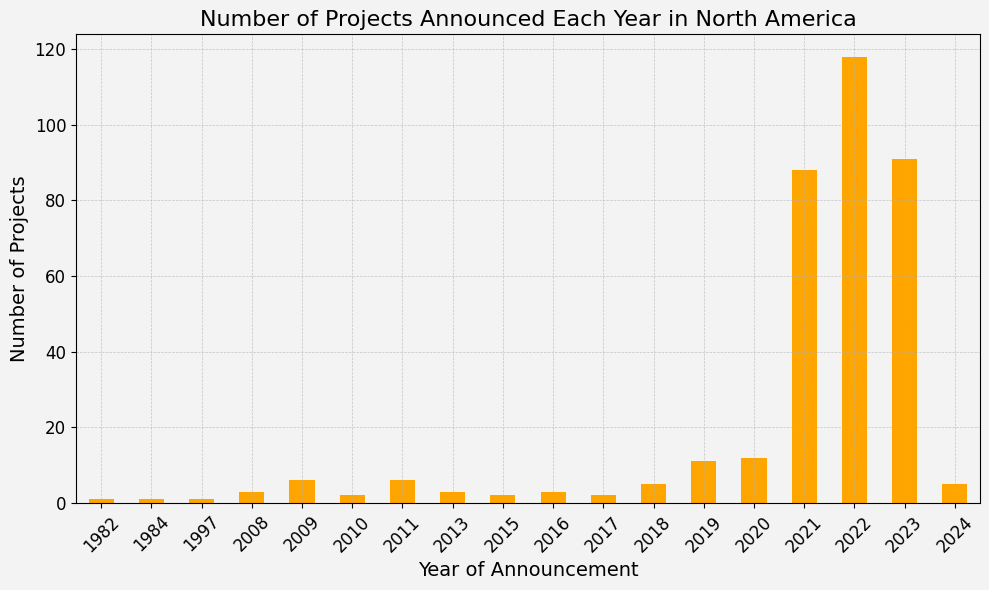

In [25]:
# Plotting the number of projects announced each year
plt.figure(figsize=(10, 6), facecolor='#F3F3F3')
ax = plt.gca()
ax.set_facecolor('#F3F3F3')

# Plotting the bar chart
projects_per_year.plot(kind='bar', color='orange')

# Customizing the plot
plt.title('Number of Projects Announced Each Year in North America', fontsize=16)
plt.xlabel('Year of Announcement', fontsize=14)
plt.ylabel('Number of Projects', fontsize=14)
ax.set_xticklabels(projects_per_year.index.astype(int), rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)  # Lighter, dashed gridlines
plt.tight_layout()

plt.show()

In [26]:
# Filter the dataset to include only projects with status 'Planned', 'Under construction', or 'Operational'
valid_status = ['Planned', 'Under construction', 'Operational']
df_filtered_status = df_north_america[df_north_america['Project Status'].isin(valid_status)]

# Select the relevant columns for analysis
filtered_projects = df_filtered_status[['Project name', 'Country', 'Project Status', 'Operation', 'Estimated capacity by IEA (Mt CO2/yr)']]

# Remove rows where 'Operation' or 'Estimated capacity by IEA (Mt CO2/yr)' is NaN
filtered_projects = filtered_projects.dropna(subset=['Operation', 'Estimated capacity by IEA (Mt CO2/yr)'])

# Sort by operation date and calculate the cumulative sum of estimated capacity by year
filtered_projects['Operation'] = filtered_projects['Operation'].astype(int)
cumulative_capacity = filtered_projects.groupby('Operation')['Estimated capacity by IEA (Mt CO2/yr)'].sum().cumsum().reset_index()

# Creating a full range of years from the first to the last operation year in the dataset
years_range = pd.DataFrame({'Operation': range(cumulative_capacity['Operation'].min(), cumulative_capacity['Operation'].max() + 1)})

# Merging the full range of years with the existing cumulative capacity data
cumulative_filled = pd.merge(years_range, cumulative_capacity, how='left', on='Operation')

# Filling missing values with the last previous available value
cumulative_filled['Estimated capacity by IEA (Mt CO2/yr)'].fillna(method='ffill', inplace=True)

# Save the final cumulative filled data to an Excel file
output_file_path = 'Cumulative_Estimated_Capacity_Filled.xlsx'
cumulative_filled.to_excel(output_file_path, index=False)

C:\Users\raeim\AppData\Local\Temp\ipykernel_74644\2391486126.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cumulative_filled['Estimated capacity by IEA (Mt CO2/yr)'].fillna(method='ffill', inplace=True)
C:\Users\raeim\AppData\Local\Temp\ipykernel_74644\2391486126.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cumulative_filled['Estimated capacity by IEA (Mt CO2/yr)'].fillna(method='ffill', inplace=True)


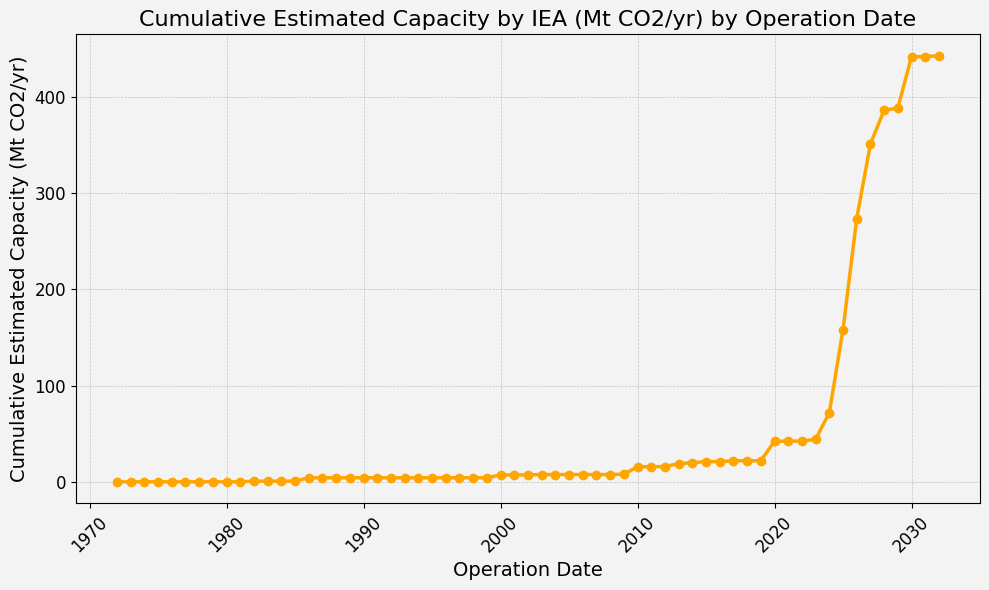

In [27]:
# Setting the background color for the whole plot and the inner plot area
plt.figure(figsize=(10, 6), facecolor='#F3F3F3')
ax = plt.gca()
ax.set_facecolor('#F3F3F3')

# Plotting the cumulative capacity over time
plt.plot(cumulative_filled['Operation'], cumulative_filled['Estimated capacity by IEA (Mt CO2/yr)'], 
         marker='o', color='orange', linewidth=2.5)

# Customizing the plot
plt.title('Cumulative Estimated Capacity by IEA (Mt CO2/yr) by Operation Date', fontsize=16)
plt.xlabel('Operation Date', fontsize=14)
plt.ylabel('Cumulative Estimated Capacity (Mt CO2/yr)', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


Cost Analysis of the CCUS Projects

In [28]:
df = pd.read_excel('CCS Map Data Jan2023.xlsx', sheet_name='Map Data')

# Filter projects in North America (assuming we're interested in United States, Canada, and Mexico)
north_america_countries = ['United States', 'Canada', 'Mexico']
df_na = df[df['Country Location'].isin(north_america_countries)]

# Keep only projects after the year 2000
if 'Project Date' in df_na.columns:
    df_na['Year'] = pd.to_datetime(df_na['Project Date'], errors='coerce').dt.year
    df_na = df_na[df_na['Year'] > 2000]

C:\Users\raeim\AppData\Local\Temp\ipykernel_74644\1346385067.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_na['Year'] = pd.to_datetime(df_na['Project Date'], errors='coerce').dt.year


In [29]:
# Display the number of projects in the US, Canada, and Mexico
project_counts = df_na['Country Location'].value_counts()
print("Number of projects in each country:")
print(project_counts)

Number of projects in each country:
Country Location
United States    144
Canada            20
Mexico             2
Name: count, dtype: int64


In [30]:
# Convert prices to USD if they are not already
currency_conversion_rates = {
    'Canadian Dollar': 0.75,  # Example conversion rate: 1 CAD = 0.75 USD
    'MXN': 0.05   # Example conversion rate: 1 MXN = 0.05 USD
}

def convert_to_usd(price, currency):
    if pd.notna(price) and currency in currency_conversion_rates:
        return price * currency_conversion_rates[currency]
    return price

if 'Cost' in df_na.columns and 'Currency Name' in df_na.columns:
    df_na['Cost (USD)'] = df_na.apply(lambda row: convert_to_usd(row['Cost'], row['Currency Name']), axis=1)
    df_na['Currency Name'] = df_na['Currency Name'].replace(currency_conversion_rates.keys(), 'US Dollar')

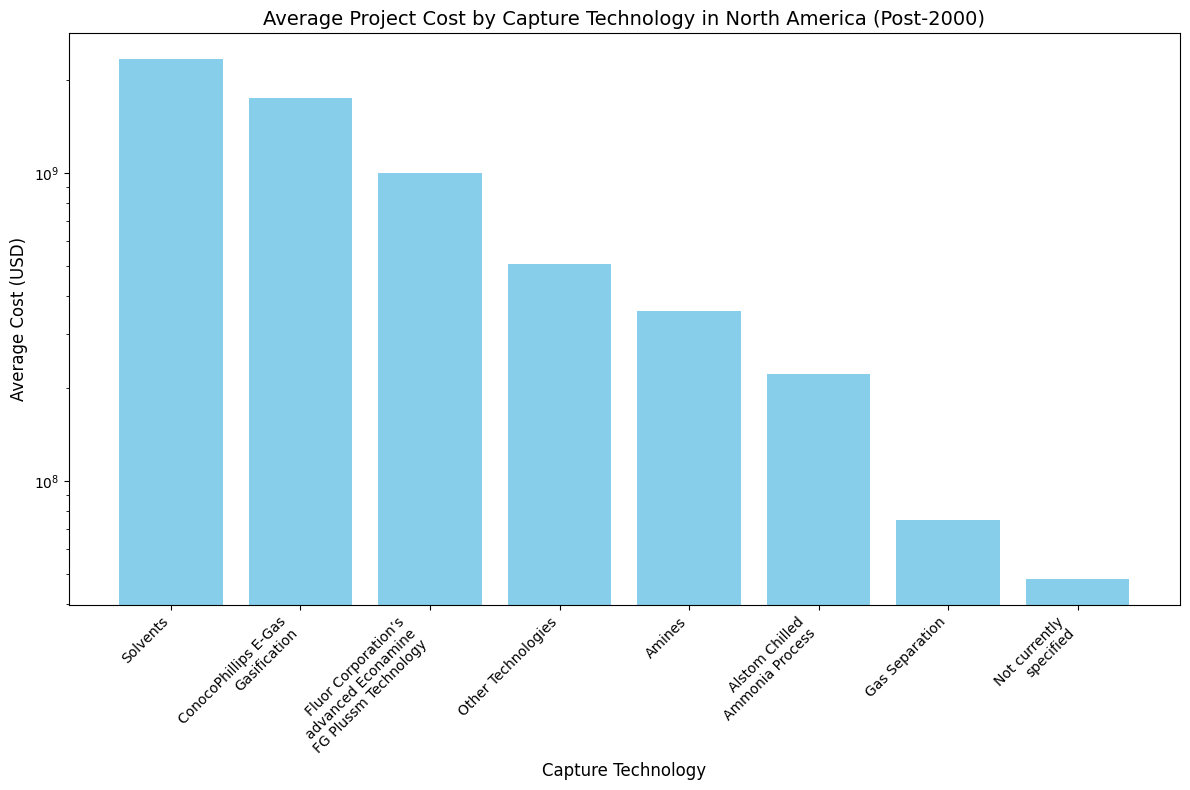

In [31]:
# Function to shorten or wrap long technology names
def shorten_labels(label):
    # If label is too long, wrap it
    return "\n".join(textwrap.wrap(label, width=20))

# Remove rows with missing 'Capture Technology' and group relevant columns
df_na_filtered = df_na[['Project Name', 'Project Date', 'Country Location', 'Capture Technology', 'Cost (USD)']].dropna(subset=['Capture Technology'])

# Group technologies with 2 or fewer projects into 'Other Technologies'
tech_counts = df_na_filtered['Capture Technology'].value_counts()
df_na_filtered['Capture Technology'] = df_na_filtered['Capture Technology'].apply(lambda x: x if tech_counts[x] > 2 else 'Other Technologies')

# Apply shortening/wrapping function to Capture Technology labels
df_na_filtered['Capture Technology'] = df_na_filtered['Capture Technology'].apply(shorten_labels)

# Remove rows where Capture Technology is "Not Currently Specified"
df_na_filtered = df_na_filtered[df_na_filtered['Capture Technology'] != 'Not Currently Specified']

# Group by Capture Technology and calculate average cost and project count
tech_avg_cost = df_na_filtered.groupby('Capture Technology').agg({'Cost (USD)': 'mean', 'Project Name': 'count'}).reset_index()
tech_avg_cost = tech_avg_cost.rename(columns={'Project Name': 'Number of Projects'})

# Sort by average cost from highest to lowest
tech_avg_cost = tech_avg_cost.sort_values(by='Cost (USD)', ascending=False)

# Plotting the bar chart of average cost by capture technology
plt.figure(figsize=(12, 8))  # Increase figure size
bars = plt.bar(tech_avg_cost['Capture Technology'], tech_avg_cost['Cost (USD)'], color='skyblue')


# Setting plot titles and labels
plt.title('Average Project Cost by Capture Technology in North America (Post-2000)', fontsize=14)
plt.xlabel('Capture Technology', fontsize=12)
plt.ylabel('Average Cost (USD)', fontsize=12)
plt.xticks(rotation=45, ha='right') 
plt.yscale('log') 
plt.tight_layout()
plt.show()


C:\Users\raeim\AppData\Local\Temp\ipykernel_74644\1190564336.py:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(box_data, patch_artist=True, labels=categories)


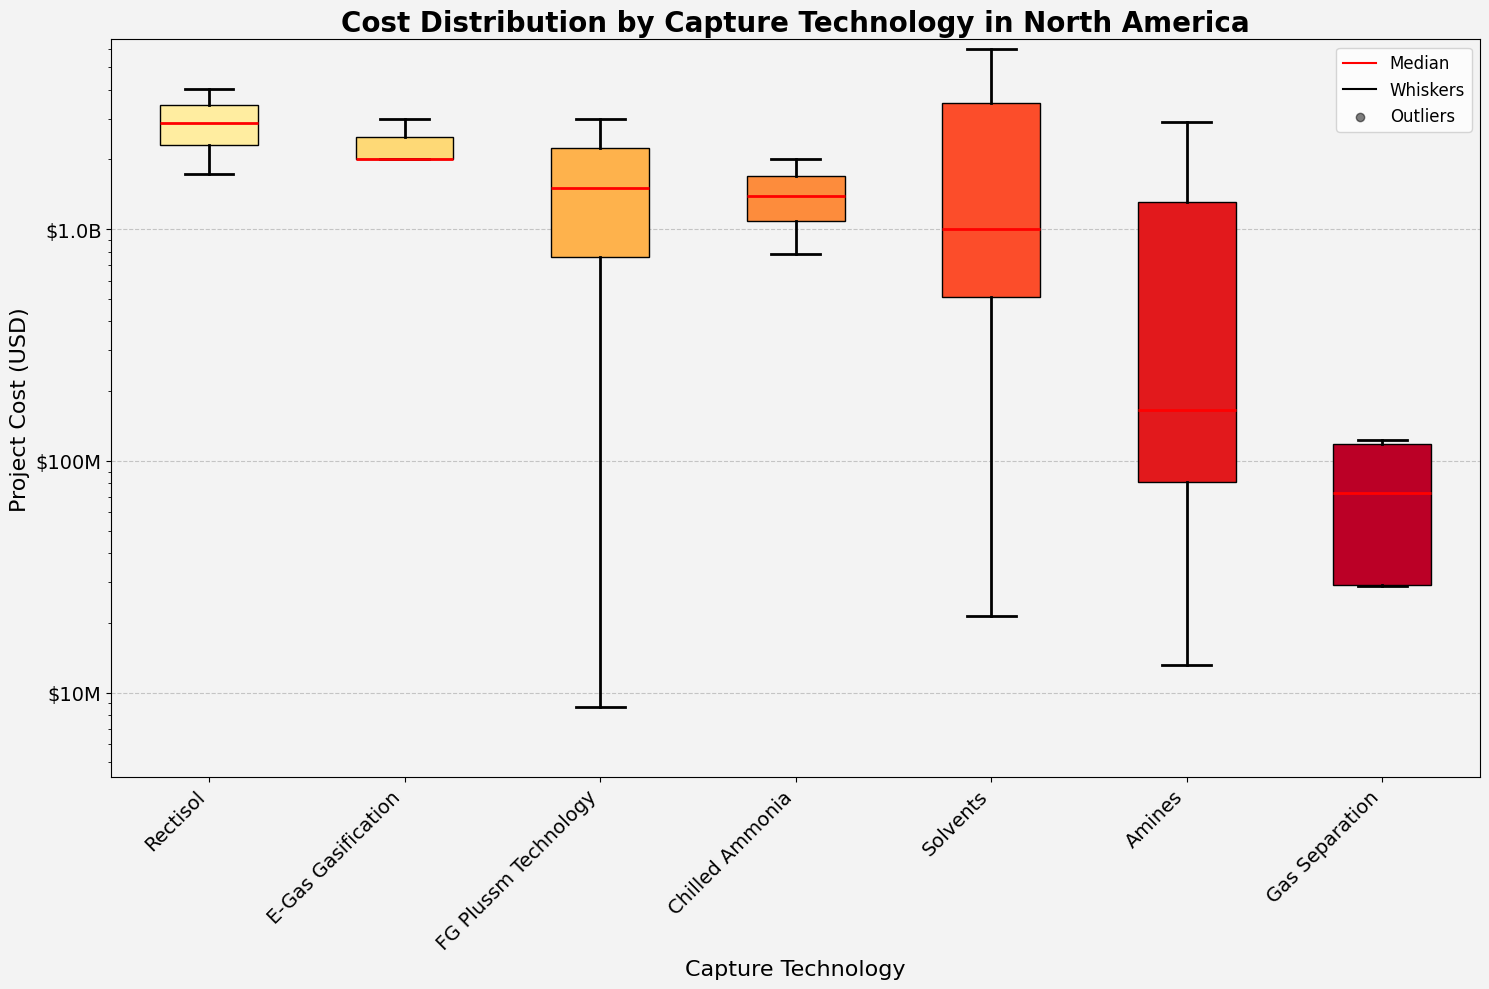

In [32]:
# Function to shorten or wrap long technology names
def shorten_labels(label):
    return "\n".join(textwrap.wrap(label, width=20))

# Filter the dataset for relevant columns and drop rows where 'Capture Technology' or 'Cost' is missing
df_na_filtered = df_na[['Project Name', 'Project Date', 'Country Location', 'Capture Technology', 'Cost']].dropna(subset=['Capture Technology', 'Cost'])

# Remove rows where 'Capture Technology' is "Not Currently Specified" and Cost is zero
df_na_filtered = df_na_filtered[
    (df_na_filtered['Capture Technology'] != 'Not currently specified') & 
    (df_na_filtered['Cost'] > 0)
]

# Count non-zero cost projects for each technology
tech_counts = df_na_filtered['Capture Technology'].value_counts()

# Filter out technologies with less than two non-zero cost projects
valid_techs = tech_counts[tech_counts >= 2].index
df_na_filtered = df_na_filtered[df_na_filtered['Capture Technology'].isin(valid_techs)]

# Update specific technology names
df_na_filtered['Capture Technology'] = df_na_filtered['Capture Technology'].replace({
    'ConocoPhillips E-Gas Gasification': 'E-Gas Gasification',
    'Fluor Corporation’s advanced Econamine FG Plussm Technology': 'FG Plussm Technology'
})

# Apply shortening/wrapping function to Capture Technology labels
df_na_filtered['Capture Technology'] = df_na_filtered['Capture Technology'].apply(shorten_labels)

# Sort the technologies by their median project cost
sorted_techs = df_na_filtered.groupby('Capture Technology')['Cost'].median().sort_values(ascending=False).index

# Sort the DataFrame based on the sorted technologies
df_na_filtered['Capture Technology'] = pd.Categorical(df_na_filtered['Capture Technology'], categories=sorted_techs, ordered=True)
df_na_filtered = df_na_filtered.sort_values('Capture Technology')


plt.figure(figsize=(15, 10), facecolor='#F3F3F3')
ax = plt.gca()
ax.set_facecolor('#F3F3F3')

# Get the sorted categories for x-ticks
categories = df_na_filtered['Capture Technology'].unique()

# Create a list of costs for each capture technology (sorted)
box_data = [df_na_filtered[df_na_filtered['Capture Technology'] == tech]['Cost'] for tech in categories]

# Use Seaborn's warm color palette
colors = sns.color_palette("YlOrRd", len(categories))

# Create a box plot using matplotlib directly
box = plt.boxplot(box_data, patch_artist=True, labels=categories)

# Color the boxes using the warm colors
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)  # Apply warm colors

# Make whiskers, caps, and medians more visible
for whisker in box['whiskers']:
    whisker.set(linewidth=2)
for cap in box['caps']:
    cap.set(linewidth=2)
for median in box['medians']:
    median.set(color='red', linewidth=2)

# Customize outliers (fliers)
for flier in box['fliers']:
    flier.set(marker='o', color='black', alpha=0.5)

# Set title and labels with larger font sizes
plt.title('Cost Distribution by Capture Technology in North America', fontsize=20, fontweight='bold')
plt.xlabel('Capture Technology', fontsize=16)
plt.ylabel('Project Cost (USD)', fontsize=16)
plt.yscale('log')

# Find the minimum value in the dataset (which is now guaranteed to be > 0)
min_value = df_na_filtered['Cost'].min()
plt.ylim(min_value / 2, df_na_filtered['Cost'].max() * 1.1)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Format y-axis labels
def format_func(value, tick_number):
    if value < 1e3:
        return f'${value:.0f}'
    elif value < 1e6:
        return f'${value/1e3:.0f}K'
    elif value < 1e9:
        return f'${value/1e6:.0f}M'
    else:
        return f'${value/1e9:.1f}B'

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_func))
plt.plot([], [], color='red', label='Median')
plt.plot([], [], color='black', label='Whiskers')
scatter = plt.scatter([], [], color='black', alpha=0.5, label='Outliers')
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()